<a href="https://colab.research.google.com/github/takumaosada/COVID-19-Basic-Analysis/blob/master/signate_phase1_covid19_case_data_pr_curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データの確認/読み込み


## データの読み込み

In [ ]:
!pip install japanize_matplotlib
!pip install category_encoders
!pip install xgboost
!pip install optuna

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import japanize_matplotlib
import category_encoders as ce
import gspread
import re
import itertools
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, learning_curve, BaseCrossValidator
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, roc_curve
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from oauth2client.client import GoogleCredentials
from google.colab import auth
import warnings
import xgboost as xgb
from IPython.display import clear_output
import optuna
import functools
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
auth.authenticate_user()

In [ ]:
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
singatecasefilelink='https://docs.google.com/spreadsheets/d/1VLSA8q2zPCbaTDXXcMsxK0HRZlFRVH7_x0rLd4Z7Jk8/edit#gid=960903158'
book = gc.open_by_url(singatecasefilelink)
casedata = book.worksheet('罹患者').get_all_values()
casedf = pd.DataFrame(casedata)

In [ ]:
#データフレームを整理していく
area_dict = dict(zip(casedf.index, casedf.iloc[0]))
renamed_df = casedf.rename(columns=area_dict)
df = renamed_df.drop(0)
df =df.drop_duplicates()
df.drop(df.index[-1]).tail()

,都道府県コード,症例番号,都道府県症例番号,発症日,確定日,公表日,受診都道府県,居住都道府県,居住市区町村,年代,性別,職業,ステータス,退院済ﾌﾗｸﾞ,基礎疾患ﾌﾗｸﾞ,症状・経過,症状一覧,行動歴,濃厚接触者状況,濃厚接触場所,海外渡航歴ﾌﾗｸﾞ,ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ,情報源,備考,罹患者関係_記入済ﾌﾗｸﾞ,罹患者トランザクション_記入済ﾌﾗｸﾞ,Relation1,Relation2,Transaction
16156,50,1,50-1,,,,中部国際空港,,,,,,,,,,,,,,,,,,0,0,,,
16157,51,27,51-27,,2020/03/27,,関西国際空港,不明,,20 - 29,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10539.html,,0,0,,,
16158,51,28,51-28,,2020/03/27,,関西国際空港,兵庫県,,非公表,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10539.html,,0,0,,,
16159,51,52,51-52,,2020/03/30,,関西国際空港,不明,,30 - 39,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10638.html,3/29ドイツから帰国,0,0,,,
16160,51,53,51-53,,2020/03/30,,関西国際空港,不明,,40 - 49,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10638.html,3/29オランダから帰国,0,0,,,


## データの確認

In [ ]:
df.describe()

,都道府県コード,症例番号,都道府県症例番号,発症日,確定日,公表日,受診都道府県,居住都道府県,居住市区町村,年代,性別,職業,ステータス,退院済ﾌﾗｸﾞ,基礎疾患ﾌﾗｸﾞ,症状・経過,症状一覧,行動歴,濃厚接触者状況,濃厚接触場所,海外渡航歴ﾌﾗｸﾞ,ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ,情報源,備考,罹患者関係_記入済ﾌﾗｸﾞ,罹患者トランザクション_記入済ﾌﾗｸﾞ,Relation1,Relation2,Transaction
count,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161
unique,51,5175,16158,218,176,178,51,73,791,12,6,121,8,6,6,5995,1812,2907,3984,226,9,4,3232,1336,2,2,1810,3164,229
top,13,1,21-150,非公表,,2020/04/11,東京都,東京都,,50 - 59,男性,,,,,,,,,,,,,,0,0,,,
freq,5162,47,2,5205,4784,674,5162,3836,4638,2636,8682,6541,9412,8836,11928,8179,10814,9974,8403,12728,10125,10885,4091,12960,11871,15934,12343,12344,13890


## データクリーニング


In [ ]:
#性別でのデータクリーニングを行う
df = df[(df['性別'] == "男性") | (df['性別'] == '女性')]
#年代でのデータクリーニングを行う
df = df[(df['年代'] != "51 - 59") & (df['年代'] != '非公表') & (df['年代'] != '')]

In [ ]:
#性別をencodeする
import category_encoders as ce
df_gender = df['性別']
list_cols = ['性別']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['性別'] = ce_ohe.fit_transform(df_gender)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [ ]:
#年代をencodeする
df_age = df['年代']
list_cols = ['年代']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['年代'] = ce_ohe.fit_transform(df_age)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



## 症状のデータの読み込み

In [ ]:
singatecasefilelink='https://docs.google.com/spreadsheets/d/1tnxt17rtmFnG4UNX8DXVXGUhCcL7-cXHE3hhoOpvfsk/edit#gid=577718303'
symptom_book = gc.open_by_url(singatecasefilelink)
symptom_data = symptom_book.worksheet('症状').get_all_values()
symptomdf = pd.DataFrame(symptom_data)

In [ ]:
area_dict = dict(zip(symptomdf.index, symptomdf.iloc[0]))
renamed_df = symptomdf.rename(columns=area_dict)
symptomdf = renamed_df.drop(0)
symptomdf =symptomdf.drop_duplicates()
symptomdf.drop(symptomdf.index[-1]).tail()

,都道府県コード,症例番号,都道府県症例番号,症状・経過,日付,症状,確認済ﾌﾗｸﾞ
126672,1,2102,1-2102,・入院先調整中\n・無症状、会話可,-,-,-
126674,1,2103,1-2103,咳、鼻汁･鼻閉、全身倦怠感\n・入院先調整中\n・軽症、会話可,-,-,-
126680,1,2104,1-2104,発熱、咳、全身倦怠感\n・医療機関Aに入院中\n・軽症、会話可,-,-,-
126685,1,2105,1-2105,発熱（38.3℃）、咳嗽\n医療機関に入院（軽症・会話可）,-,-,-
126690,1,2106,1-2106,医療機関への入院に向け調整中（無症状）,-,-,-


In [ ]:
symptomdf = symptomdf[(symptomdf['症状'] != "-")]

In [ ]:
symptoms = symptomdf["症状"].unique()
symptoms_list = list()
for element in symptoms:
  elements = re.split('[;，]', element)
  symptoms_list.append(elements)

In [ ]:
unique_symptons_list = list(itertools.chain.from_iterable(symptoms_list))
unique_symptons_list = list(set(unique_symptons_list))

In [ ]:
#不要な要素を取り除く
# 検査しないとわからない項目は取り除く
# 今回は死亡、受診、入院、退院、肺炎を取り除く
# 追加で呼吸困難は影響が大きすぎるので排除する
cleaned_symptoms_list = list()
for element in unique_symptons_list:
  if not ("icd" in element or "受診" in element or "死亡" in element):
    if not ("入院" in element or "肺炎" in element or "退院" in element or "呼吸困難" in element):
        cleaned_symptoms_list.append(element)

In [ ]:
cleaned_symptoms_list

['',
 '関節炎',
 '食欲不振',
 '肩部痛',
 '呼吸不全',
 'ほてり',
 '項部痛',
 '急性耳痛',
 '腹部不快感',
 '寝汗',
 '摂食機能障害',
 '咽喉頭異常感症',
 '喉頭炎',
 '血尿',
 '片頭痛',
 '口内炎',
 '拡張相肥大型心筋症',
 '鼻痛',
 '意識消失',
 '嗅覚異常',
 '神経痛',
 '気管支炎',
 '咳喘息',
 '下肢しびれ',
 '検診',
 '急性上気道炎',
 '過剰喀痰',
 '鼻汁',
 '血腫',
 '倦怠感',
 '脱水症',
 'つかえ感',
 '敗血症性ショック',
 '嚥下障害',
 '聴覚障害',
 '摂食障害',
 '咽頭痛',
 '全身痛',
 '耳痛症',
 '結膜充血',
 '胸部異常陰影',
 '筋肉痛',
 '扁桃炎',
 '項部腫脹',
 '鼻閉感',
 '脱力感',
 'ぶどう球菌感染症',
 '体力低下',
 '貧血',
 '息切れ',
 '咳',
 '胃腸疾患',
 '全身倦怠感',
 '胃痛',
 '肩こり',
 '発熱',
 '悪寒',
 '微熱',
 '眼痛',
 '吐血',
 '喉頭痛',
 'くしゃみ',
 'こむら返り',
 '後頭部痛',
 '歯痛',
 '悪寒戦慄',
 '乾性咳',
 '発音障害',
 '鼻炎',
 '頚部痛',
 'かぜ',
 'ブラ',
 'アデノウイルス感染症',
 '骨折',
 '窒息感',
 '心肺停止',
 '湿疹',
 'よう',
 '健康相談',
 '前胸部痛',
 '腰痛症',
 '腰殿部痛',
 '咽頭炎',
 '筋力低下',
 '鼻閉',
 'ピリピリ感',
 '脂質異常症',
 '不明熱',
 '嗅覚障害',
 '尿路感染症',
 '発汗障害',
 '嘔吐症',
 '異常喀痰',
 '特発性拡張型心筋症',
 '眼精疲労',
 '感冒',
 '関節痛',
 '下腹痛',
 '心配',
 '起立性眩暈',
 '四肢しびれ',
 '老衰',
 '胸部不快感',
 '口渇症',
 '敗血症',
 '背部痛',
 '歩行困難',
 '咽頭異常感症',
 '上腹部痛',
 '心不全',
 '急性鼻炎',
 '胸内苦悶',
 '意識障害',
 '疼痛',
 '血痰',
 '頻尿症',
 '不安障

# 勾配ブースティング法を用いたモデルの作成


## データの整理

In [ ]:
df_new = df[["都道府県コード", "年代", "性別", "ステータス", "症状一覧"]]

In [ ]:
# ステータスは`非公開`や``をdropし、死亡を４、重症を3、中等症を２、軽症、無症状を1とする
df_new = df_new[(df['ステータス'] == "重症") | (df['ステータス'] == '軽症') | (df['ステータス'] == '死亡') | (df['ステータス'] == '無症状') | (df['ステータス'] == '中等症')]
df_new["ステータス"] = df_new["ステータス"].str.replace("重症", "1").str.replace("死亡", "1").str.replace("中等症", "0").str.replace("軽症", "0").str.replace("無症状", "0")
df_new["ステータス"] = df_new["ステータス"].astype(int)

In [ ]:
for element in cleaned_symptoms_list:
  df_new[element] = df_new["症状一覧"].str.contains(element)

In [ ]:
df_new["都道府県コード"] = df_new["都道府県コード"].astype(int)

In [ ]:
# 症状一覧をdropする
df_new = df_new.drop('症状一覧', axis=1)

## XGBoostを用いるケース

In [ ]:
params1 = {
    'n_estimators': 5000,
    'max_depth': 7,
    'objective':'reg:linear',
    'min_child_weight': 4,
    'eta': 0.07,
    'eval_metric': 'mae',
}

params2 = {
    'n_estimators': 5000,
    'max_depth': 7,
    'objective':'reg:linear',
    'min_child_weight': 4,
    'eta': 0.07,
    'eval_metric': 'auc',
}

In [ ]:
def plot_xgboost_result(df):
  # モデルの作成(xgboost)
  x_train, x_test, y_train, y_test = train_test_split(df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1), df['ステータス'], stratify=df['ステータス'], test_size=0.3, random_state=0)

  dtrain = xgb.DMatrix(x_train, label=y_train)
  dtest = xgb.DMatrix(x_test, label=y_test)

  evals = [(dtrain, 'train'), (dtest, 'test')]

  evals_result = {}

  model1= xgb.train(
      params1,
      dtrain,
      num_boost_round=5000,
      evals=evals,
      early_stopping_rounds=30,
      evals_result=evals_result,
          )
  clear_output()

  y_pred = model1.predict(dtest)
  y_true = y_test.values

  train_metric = evals_result['train']['mae']
  eval_metric = evals_result['test']['mae']
  fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(24,15))
  axes[0,0].plot(train_metric, label='train mae')
  axes[0,0].plot(eval_metric, label='test mae', linestyle='dashed')
  axes[0,0].grid()
  axes[0,0].legend()
  axes[0,0].set_xlabel('学習回数')
  axes[0,0].set_ylabel('平均絶対誤差')

  xgb.plot_importance(model1, ax=axes[0,1], importance_type='gain', title='項目の重要度', show_values=False)
  axes[0,1].set_ylabel("項目")

  evals = [(dtrain, 'train'), (dtest, 'test')]

  evals_result = {}

  # モデルの作成(AUC)
  model2 = xgb.train(
      params2,
      dtrain,
      num_boost_round=5000,
      evals=evals,
      early_stopping_rounds=30,
      evals_result=evals_result,
          )
  clear_output()

  check = model2.predict(dtest)
  fpr, tpr, thresholds = roc_curve(y_true, check)
  axes[1,0].plot(fpr, tpr, marker='o')
  axes[1,0].set_xlabel('FPR: False positive rate')
  axes[1,0].set_ylabel('TPR: True positive rate')
  axes[1,0].grid()

  history = xgb.cv(params1, dtrain, num_boost_round=200, early_stopping_rounds=10, nfold=10, verbose_eval=False, stratified=True)
  train_metric = history['train-mae-mean']
  eval_metric = history['test-mae-mean']
  axes[1,1].plot(train_metric, label='train mae')
  axes[1,1].plot(eval_metric, label='eval mae', linestyle='dashed')
  axes[1,1].grid()
  axes[1,1].legend()
  axes[1,1].set_xlabel('round')
  axes[1,1].set_ylabel('mae')
  print("重症,死亡の患者の数", df['ステータス'].value_counts()[1], '-', df['ステータス'].value_counts()[0])
  print("AUCのベストスコア", model2.best_score)

In [ ]:
def cross_validation(df, random_state = 0):
  x = df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1)
  y = df['ステータス']
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=random_state)
  model = LogisticRegression().fit(x_train, y_train)
  kf_with_shuffle = KFold(n_splits = 10, shuffle = True, random_state = random_state)
  kf_without_shuffle = KFold(n_splits = 10, shuffle = False, random_state = random_state)
  strat_kf_with_shuffle = StratifiedKFold(n_splits=10, shuffle=True, random_state= random_state)
  strat_kf_withøut_shuffle = StratifiedKFold(n_splits=10, shuffle=True, random_state= random_state)
  test_data_score = model.score(x_test, y_test)
  kfold_scores_with_shuffle = cross_val_score(model, x, y, cv=kf_with_shuffle)
  kfold_scores_without_shuffle = cross_val_score(model, x, y, cv=kf_without_shuffle)
  strat_kfold_score_with_shuffle = cross_val_score(model, x, y, cv=strat_kf_with_shuffle)
  strat_kfold_score_without_shuffle = cross_val_score(model, x, y, cv=strat_kf_withøut_shuffle)
  print("random_stateの値", random_state)
  print("テストデータのスコア", test_data_score)
  print("交差検証のスコア平均(シャッフルあり)", kfold_scores_with_shuffle.mean())
  print("交差検証のスコア平均(シャッフルなし)", kfold_scores_without_shuffle.mean())
  print("層化k分割交差検証のスコア平均(シャッフルあり)", strat_kfold_score_with_shuffle.mean())
  print("層化k分割交差検証のスコア平均(シャッフルなし)", strat_kfold_score_without_shuffle.mean())

In [ ]:
# 重症患者の割合が少ないことから予測値が全て軽傷患者である判定をしてしまっている
# そのため不均衡データ分析を行う必要がある
# 今回はオーバーサンプリングとアンダーサンプリングの２種類を用いて不均衡なデータでも十分な分析ができるようにする

## LightGBMを用いるケース

In [ ]:
# サンプリングレートを元に確率を補正する
def probability_calibration(y_proba, beta):
    calibrated_proba = y_proba / (y_proba + (1 - y_proba) / beta)
    return calibrated_proba

In [ ]:
def calcurate_precision(test_data, data, percentage):
  p_1 = np.array(data)[test_data == 1]
  cal_percentage = 1 - percentage
  p_1_q = np.quantile(p_1,cal_percentage)
  y_q = test_data[np.array(data)>p_1_q]
  if sum(y_q) != 0:
    print('recallが', percentage, 'の割合で指定された時のprecision', sum(y_q)/len(y_q))

In [ ]:
def check_classification(df):
  x = df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1)
  y = df['ステータス']
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

  # まずは不均衡データのままロジスティック回帰モデルを学習させる
  clf = LogisticRegression(random_state=42, solver='lbfgs')
  clf.fit(X_train, y_train)
  # 検証用データを予測させる
  y_pred_proba_base = clf.predict_proba(X_test)[:, 1]
  y_pred_base = np.where(y_pred_proba_base > 0.9, 1, 0)

  # Recallを指定した時のprecisionを調べる
  for percentage in [round(i * 0.1, 1) for i in range(1, 10)]:
    calcurate_precision(y_test, y_pred_proba_base, percentage)

  # Under-sampling で均衡データにする
  sampler = RandomUnderSampler(random_state=42)
  X_train_sampled, y_train_sampled = sampler.fit_sample(X_train, y_train)

  # Over-sampling で均衡データにする
  over_sampler = SMOTE(random_state=42)
  X_train_over_sampled, y_train_over_sampled = over_sampler.fit_sample(X_train, y_train)

  # Under-samplingの均衡データでロジスティック回帰モデルを学習させる
  clf = LogisticRegression(random_state=42, solver='lbfgs')
  clf.fit(X_train_sampled, y_train_sampled)
  # Under-samplingの検証用データを予測させる
  y_pred_proba_us = clf.predict_proba(X_test)[:, 1]
  y_pred_us = np.where(y_pred_proba_us > 0.9, 1, 0)


  # Over-samplingの均衡データでロジスティック回帰モデルを学習させる
  clf = LogisticRegression(random_state=42, solver='lbfgs')
  clf.fit(X_train_over_sampled, y_train_over_sampled)
  # Over-samplingの検証用データを予測させる
  y_pred_proba_os = clf.predict_proba(X_test)[:, 1]
  y_pred_os = np.where(y_pred_proba_os > 0.9, 1, 0)

  # サンプリングレートを元に確率を補正する
  y_train_zero_len = np.count_nonzero(y_train_sampled == 0)
  beta = y_train_zero_len / len(y_train)
  y_pred_proba_cb = probability_calibration(y_pred_proba_us, beta)
  y_pred_cb = np.where(y_pred_proba_cb > 0.9, 1, 0)

  # Recallを指定した時のprecisionを調べる
  for percentage in [round(i * 0.1, 1) for i in range(1, 10)]:
    calcurate_precision(y_test, y_pred_proba_cb, percentage)

  # 各種評価指標を出力する
  # 精度
  print('precision (base): ', metrics.precision_score(y_test, y_pred_base))
  print('precision (under-sampling): ', metrics.precision_score(y_test, y_pred_us))
  print('precision (over-sampling): ', metrics.precision_score(y_test, y_pred_os))
  print('precision (calibrated): ', metrics.precision_score(y_test, y_pred_cb))
  # 検出率
  print('recall (base): ', metrics.recall_score(y_test, y_pred_base))
  print('recall (under-sampling): ', metrics.recall_score(y_test, y_pred_us))
  print('recall (over-sampling): ', metrics.recall_score(y_test, y_pred_os))
  print('recall (calibrated): ', metrics.recall_score(y_test, y_pred_cb))
  # F値
  print('F1 (base): ', metrics.f1_score(y_test, y_pred_base))
  print('F1 (under-sampling): ', metrics.f1_score(y_test, y_pred_us))
  print('F1 (over-sampling): ', metrics.f1_score(y_test, y_pred_os))
  print('F1 (calibrated): ', metrics.f1_score(y_test, y_pred_cb))
  # ROC
  print('ROC AUC (base): ', metrics.roc_auc_score(y_test, y_pred_base))
  print('ROC AUC (under-sampling): ', metrics.roc_auc_score(y_test, y_pred_us))
  print('ROC AUC (over-sampling): ', metrics.roc_auc_score(y_test, y_pred_os))
  print('ROC AUC (calibrated): ', metrics.roc_auc_score(y_test, y_pred_cb))

  # 各モデルが予測した内容の統計量
  print('y_test mean', y_test.mean())
  print('y_proba mean (base)', y_pred_proba_base.mean())
  print('y_proba mean (under-sampling)', y_pred_proba_us.mean())
  print('y_proba mean (over-sampling)', y_pred_proba_os.mean())
  print('y_proba mean (calibrated)', y_pred_proba_cb.mean())

  # キャリブレーションカーブを計算する
  base_curve = calibration_curve(y_test, y_pred_proba_base, n_bins=10)
  undersampling_curve = calibration_curve(y_test, y_pred_proba_us, n_bins=10)
  oversampling_curve = calibration_curve(y_test, y_pred_proba_os, n_bins=10)
  calibrated_curve = calibration_curve(y_test, y_pred_proba_cb, n_bins=10)

  # プロットする
  fig, axes = plt.subplots(2, 1, figsize=(8, 7))

  ax1 = axes[0]
  ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
  ax1.plot(base_curve[0], base_curve[1], label='base')
  ax1.plot(undersampling_curve[0], undersampling_curve[1], label='under-sampling')
  ax1.plot(oversampling_curve[0], oversampling_curve[1], label='over-sampling')
  ax1.plot(calibrated_curve[0], calibrated_curve[1], label='calibrated')

  ax1.grid()
  ax1.set_ylabel('Fraction of positives')
  ax1.set_xlabel('Prediction probability')
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend(loc='lower right')

  ax2 = axes[1]
  ax2.hist(y_pred_proba_base, bins=144, alpha=0.5, color='red', label='y_pred_proba (base)')
  ax2.hist(y_pred_proba_us, bins=144, alpha=0.5, color='orange', label='y_pred_proba (under-sampling)')
  ax2.hist(y_pred_proba_os, bins=144, alpha=0.5, color='blue', label='y_pred_proba (over-sampling)')
  ax2.hist(y_pred_proba_cb, bins=144, alpha=0.5, color='green', label='y_pred_proba (calibrated)')
  ax2.axvline(x=y_test.mean(), color='blue', label='y_test mean')
  ax2.axvline(x=y_pred_proba_base.mean(), color='red', label='y_proba mean (base)')
  ax2.axvline(x=y_pred_proba_us.mean(), color='orange', label='y_proba mean (under-sampling)')
  ax2.axvline(x=y_pred_proba_os.mean(), color='blue', label='y_proba mean (over-sampling)')
  ax2.axvline(x=y_pred_proba_cb.mean(), color='green', label='y_proba mean (calibrated)')

  ax2.set_xlabel('Prediction Probability')
  ax2.set_ylabel('Frequency')

  plt.legend()
  plt.show()

recallが 0.2 の割合で指定された時のprecision 0.05759162303664921
recallが 0.3 の割合で指定された時のprecision 0.08928571428571429
recallが 0.4 の割合で指定された時のprecision 0.0975609756097561
recallが 0.5 の割合で指定された時のprecision 0.10179640718562874
recallが 0.6 の割合で指定された時のprecision 0.09069767441860466
recallが 0.7 の割合で指定された時のprecision 0.08333333333333333
recallが 0.8 の割合で指定された時のprecision 0.07528409090909091
recallが 0.9 の割合で指定された時のprecision 0.07711442786069651


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs fail

recallが 0.1 の割合で指定された時のprecision 0.007042253521126761
recallが 0.2 の割合で指定された時のprecision 0.06043956043956044
recallが 0.3 の割合で指定された時のprecision 0.08333333333333333
recallが 0.4 の割合で指定された時のprecision 0.09352517985611511
recallが 0.5 の割合で指定された時のprecision 0.09696969696969697
recallが 0.6 の割合で指定された時のprecision 0.0891304347826087
recallが 0.7 の割合で指定された時のprecision 0.08348134991119005
recallが 0.8 の割合で指定された時のprecision 0.07417974322396577
recallが 0.9 の割合で指定された時のprecision 0.07011494252873564
precision (base):  0.0
precision (under-sampling):  0.0
precision (over-sampling):  0.0
precision (calibrated):  0.0
recall (base):  0.0
recall (under-sampling):  0.0
recall (over-sampling):  0.0
recall (calibrated):  0.0
F1 (base):  0.0
F1 (under-sampling):  0.0
F1 (over-sampling):  0.0
F1 (calibrated):  0.0
ROC AUC (base):  0.5
ROC AUC (under-sampling):  0.5
ROC AUC (over-sampling):  0.5
ROC AUC (calibrated):  0.5
y_test mean 0.05968858131487889
y_proba mean (base) 0.05268273123381248
y_proba mean (under-sampling) 0

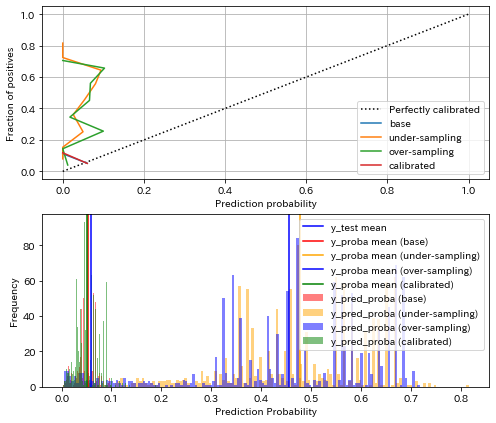

In [ ]:
check_classification(df_new)

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.174072
[20]	valid_0's binary_logloss: 0.168207
[30]	valid_0's binary_logloss: 0.16662
[40]	valid_0's binary_logloss: 0.167392
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.166484
recallが 0.2 の割合で指定された時のprecision 0.2826086956521739
recallが 0.3 の割合で指定された時のprecision 0.2826086956521739
recallが 0.4 の割合で指定された時のprecision 0.2708333333333333
recallが 0.5 の割合で指定された時のprecision 0.19653179190751446
recallが 0.6 の割合で指定された時のprecision 0.17857142857142858
recallが 0.7 の割合で指定された時のprecision 0.14814814814814814
recallが 0.8 の割合で指定された時のprecision 0.13829787234042554
recallが 0.9 の割合で指定された時のprecision 0.10777385159010601


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

[10]	cv_agg's binary_logloss: 0.548794 + 0.0342739
[20]	cv_agg's binary_logloss: 0.525735 + 0.046926
[30]	cv_agg's binary_logloss: 0.518289 + 0.0525071
[40]	cv_agg's binary_logloss: 0.516524 + 0.0555879
[50]	cv_agg's binary_logloss: 0.516443 + 0.0552117
recallが 0.2 の割合で指定された時のprecision 0.3125
recallが 0.3 の割合で指定された時のprecision 0.2923076923076923
recallが 0.4 の割合で指定された時のprecision 0.24347826086956523
recallが 0.5 の割合で指定された時のprecision 0.2125
recallが 0.6 の割合で指定された時のprecision 0.1872146118721461
recallが 0.7 の割合で指定された時のprecision 0.16725978647686832
recallが 0.8 の割合で指定された時のprecision 0.13866666666666666
recallが 0.9 の割合で指定された時のprecision 0.113345521023766
precision (base):  0.0
precision (under-bagging):  0.0
precision (calibrated):  0.0
recall (base):  0.0
recall (under-bagging):  0.0
recall (calibrated):  0.0
F1 (base):  0.0
F1 (under-bagging):  0.0
F1 (calibrated):  0.0
ROC AUC (base):  0.5
ROC AUC (under-bagging):  0.5
ROC AUC (calibrated):  0.5
y_test mean 0.05968858131487889
y_proba mean (base) 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



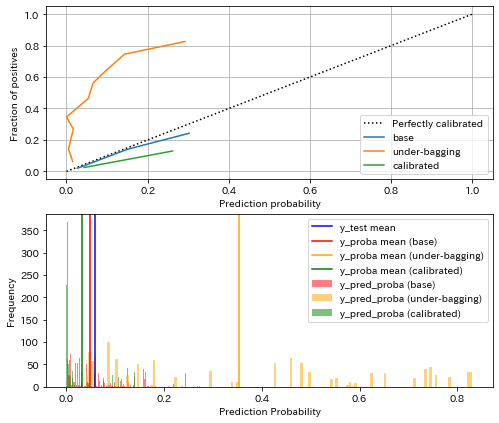

In [ ]:
class UnderBaggingKFold(BaseCrossValidator):
    '''CV に使うだけで UnderBagging できるKFold実装(少ないクラスのデータは各 Fold で重複して選択される)'''

    def __init__(self, n_splits=5, shuffle=True, random_states=None, test_size=0.2, whole_testing=False):
        '''
        :param n_splits: Fold の分割数
        :param shuffle: 分割時にデータをシャッフルするか
        :param random_states: 各 Fold の乱数シード
        :param test_size: Under-sampling された中でテスト用データとして使う割合
        :param whole_testing: Under-sampling で選ばれなかった全てのデータをテスト用データに追加するか
        '''
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_states = random_states
        self.test_size = test_size
        self.whole_testing = whole_testing

        self.sample_indices_ = []

        if random_states is not None:
            # 各 Fold の乱数シードが指定されているなら分割数をそれに合わせる
            self.n_splits = len(random_states)
        else:
            # 乱数シードが指定されていないときは分割数だけ None で埋めておく
            self.random_states = [None] * self.n_splits

        # 分割数だけ Under-sampling 用のインスタンスを作っておく
        self.samplers_ = [
            RandomUnderSampler(random_state=random_state)
            for random_state in self.random_states
        ]

    def split(self, X, y=None, groups=None):
        '''データを学習用とテスト用に分割する'''
        if X.ndim < 2:
            # RandomUnderSampler#fit_resample() は X が 1d-array だと文句を言う
            X = np.vstack(X)

        for i in range(self.n_splits):
            # データを Under-sampling して均衡データにする
            sampler = self.samplers_[i]
            _, y_sampled = sampler.fit_resample(X, y)
            # 選ばれたデータのインデックスを取り出す
            sampled_indices = sampler.sample_indices_

            # 選ばれたデータのインデックスを記録しておく
            self.sample_indices_ = sampled_indices

            # 選ばれたデータを学習用とテスト用に分割する
            split_data = train_test_split(sampled_indices, shuffle=self.shuffle, test_size=self.test_size, stratify=y_sampled, random_state=self.random_states[i],)
            train_indices, test_indices = split_data

            if self.whole_testing:
                # Under-sampling で選ばれなかったデータをテスト用に追加する
                mask = np.ones(len(X), dtype=np.bool)
                mask[sampled_indices] = False
                X_indices = np.arange(len(X))
                non_sampled_indices = X_indices[mask]
                test_indices = np.concatenate([test_indices, non_sampled_indices])

            yield train_indices, test_indices

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits


class ModelExtractionCallback(object):
    # lightgbm.cv() から学習済みモデルを取り出すためのコールバックに使うクラス

    def __init__(self):
        self._model = None

    def __call__(self, env):
        # _CVBooster の参照を保持する
        self._model = env.model

    def _assert_called_cb(self):
        if self._model is None:
            # コールバックが呼ばれていないときは例外にする
            raise RuntimeError('callback has not called yet')

    @property
    def boosters_proxy(self):
        self._assert_called_cb()
        # Booster へのプロキシオブジェクトを返す
        return self._model

    @property
    def raw_boosters(self):
        self._assert_called_cb()
        # Booster のリストを返す
        return self._model.boosters

    @property
    def best_iteration(self):
        self._assert_called_cb()
        # Early stop したときの boosting round を返す
        return self._model.best_iteration

def calcurate_precision(test_data, data, percentage):
  p_1 = np.array(data)[test_data == 1]
  cal_percentage = 1 - percentage
  p_1_q = np.quantile(p_1,cal_percentage)
  y_q = test_data[np.array(data)>p_1_q]
  if sum(y_q) != 0:
    print('recallが', percentage, 'の割合で指定された時のprecision', sum(y_q)/len(y_q))

def main():
    df = df_new
    df.columns = list(range(len(df.columns)))
    X = df.drop(0, axis=1).drop(3, axis=1)
    y = df[3]

    # 学習用データと検証用データに分割する (Hold-out)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # まずは不均衡データのまま学習させる
    lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
    }
    X_tr, X_ev, y_tr, y_ev = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_ev, y_ev, reference=lgb_train)
    booster = lgb.train(lgb_params, lgb_train, valid_sets=lgb_eval, num_boost_round=1000, early_stopping_rounds=10, verbose_eval=10)

    # 検証用データを予測させる
    y_pred_proba_base = booster.predict(X_test)
    y_pred_base = np.where(y_pred_proba_base > 0.9, 1, 0)

    # Recallを指定した時のprecisionを調べる
    for percentage in [round(i * 0.1, 1) for i in range(1, 10)]:
      calcurate_precision(y_test, y_pred_proba_base, percentage)

    # 均衡データで学習させる (UnderBagging)
    folds = UnderBaggingKFold(random_states=range(42, 42 + 5))
    lgb_train = lgb.Dataset(X_train, y_train)
    extraction_cb = ModelExtractionCallback()
    callbacks = [
        extraction_cb,
    ]
    lgb.cv(lgb_params, lgb_train,
           num_boost_round=1000,
           early_stopping_rounds=10,
           folds=folds,
           callbacks=callbacks,
           verbose_eval=10)
    cv_booster = extraction_cb.boosters_proxy
    # 検証用データを予測させる
    y_pred_proba_ub_list = cv_booster.predict(X_test)
    y_pred_proba_ub = np.array(y_pred_proba_ub_list).mean(axis=0)
    y_pred_ub = np.where(y_pred_proba_ub > 0.9, 1, 0)

    # サンプリングレートを元に確率を補正する
    y_sampled = y_train.reindex(folds.sample_indices_)
    y_sampled_negative_len = np.count_nonzero(y_sampled == 0)
    beta = y_sampled_negative_len / len(y_train)
    y_pred_proba_cb = probability_calibration(y_pred_proba_ub, beta)
    y_pred_cb = np.where(y_pred_proba_cb > 0.9, 1, 0)

    # Recallを指定した時のprecisionを調べる
    for percentage in [round(i * 0.1, 1) for i in range(1, 10)]:
      calcurate_precision(y_test, y_pred_proba_cb, percentage)

    # 各種評価指標を出力する
    print('precision (base): ', metrics.precision_score(y_test, y_pred_base))
    print('precision (under-bagging): ', metrics.precision_score(y_test, y_pred_ub))
    print('precision (calibrated): ', metrics.precision_score(y_test, y_pred_cb))
    print('recall (base): ', metrics.recall_score(y_test, y_pred_base))
    print('recall (under-bagging): ', metrics.recall_score(y_test, y_pred_ub))
    print('recall (calibrated): ', metrics.recall_score(y_test, y_pred_cb))
    print('F1 (base): ', metrics.f1_score(y_test, y_pred_base))
    print('F1 (under-bagging): ', metrics.f1_score(y_test, y_pred_ub))
    print('F1 (calibrated): ', metrics.f1_score(y_test, y_pred_cb))
    print('ROC AUC (base): ', metrics.roc_auc_score(y_test, y_pred_base))
    print('ROC AUC (under-bagging): ', metrics.roc_auc_score(y_test, y_pred_ub))
    print('ROC AUC (calibrated): ', metrics.roc_auc_score(y_test, y_pred_cb))

    # 各モデルが予測した内容の統計量
    print('y_test mean', y_test.mean())
    print('y_proba mean (base)', y_pred_proba_base.mean())
    print('y_proba mean (under-sampling)', y_pred_proba_ub.mean())
    print('y_proba mean (calibrated)', y_pred_proba_cb.mean())

    # キャリブレーションカーブを計算する
    base_curve = calibration_curve(y_test, y_pred_proba_base, n_bins=10)
    underbagging_curve = calibration_curve(y_test, y_pred_proba_ub, n_bins=10)
    calibrated_curve = calibration_curve(y_test, y_pred_proba_cb, n_bins=10)

    # プロットする
    fig, axes = plt.subplots(2, 1, figsize=(8, 7))

    ax1 = axes[0]
    ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
    ax1.plot(base_curve[0], base_curve[1], label='base')
    ax1.plot(underbagging_curve[0], underbagging_curve[1], label='under-bagging')
    ax1.plot(calibrated_curve[0], calibrated_curve[1], label='calibrated')

    ax1.grid()
    ax1.set_ylabel('Fraction of positives')
    ax1.set_xlabel('Prediction probability')
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc='lower right')

    ax2 = axes[1]
    ax2.hist(y_pred_proba_base, bins=144, alpha=0.5, color='red', label='y_pred_proba (base)')
    ax2.hist(y_pred_proba_ub, bins=144, alpha=0.5, color='orange', label='y_pred_proba (under-bagging)')
    ax2.hist(y_pred_proba_cb, bins=144, alpha=0.5, color='green', label='y_pred_proba (calibrated)')
    ax2.axvline(x=y_test.mean(), color='blue', label='y_test mean')
    ax2.axvline(x=y_pred_proba_base.mean(), color='red', label='y_proba mean (base)')
    ax2.axvline(x=y_pred_proba_ub.mean(), color='orange', label='y_proba mean (under-bagging)')
    ax2.axvline(x=y_pred_proba_cb.mean(), color='green', label='y_proba mean (calibrated)')

    ax2.set_xlabel('Prediction Probability')
    ax2.set_ylabel('Frequency')

    plt.legend()
    plt.show()


if __name__ == '__main__':
    main()

# 各地域に対してモデルの適用

## 全体(重傷者312人/全体5465人)

In [ ]:
# 都道府県の項目は外す
# plot_xgboost_result(df_new)

In [ ]:
warnings.filterwarnings('ignore')
cross_validation(df_new)

## 東京のみ(重傷者4人/全体222人)

In [ ]:
# df_new_tokyo = df_new[df_new["都道府県コード"] == 13]
# plot_xgboost_result(df_new_tokyo)

In [ ]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_tokyo)

## 神奈川のみ(重傷者56人/全体806人)

In [ ]:
# df_new_kanagawa = df_new[df_new["都道府県コード"] == 14]
# plot_xgboost_result(df_new_kanagawa)

In [ ]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_kanagawa)

## 北海道のみ(重傷者34人/全体924人)

In [ ]:
# df_new_hokkaido = df_new[df_new["都道府県コード"] == 1]
# plot_xgboost_result(df_new_hokkaido)

In [ ]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_hokkaido)

## 近畿地方(重傷者169人/全体1878人)

In [ ]:
# df_new_kinki = df_new[(df_new["都道府県コード"] == 24) | (df_new["都道府県コード"] == 25) | (df_new["都道府県コード"] == 26) | (df_new["都道府県コード"] == 27) | (df_new["都道府県コード"] == 28) | (df_new["都道府県コード"] == 29) | (df_new["都道府県コード"] == 30)]
# plot_xgboost_result(df_new_kinki)

In [ ]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_kinki)

## 関東地方(重傷者72人/全体1552人)

In [ ]:
# df_new_kanto = df_new[(df_new["都道府県コード"] == 8) | (df_new["都道府県コード"] == 9) | (df_new["都道府県コード"] == 10) | (df_new["都道府県コード"] == 11) | (df_new["都道府県コード"] == 12) | (df_new["都道府県コード"] == 13) | (df_new["都道府県コード"] == 14)]
# plot_xgboost_result(df_new_kanto)

In [ ]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_kanto)

## 中部地方(重傷者33人/全体651人)

In [ ]:
# df_new_chubu = df_new[(df_new["都道府県コード"] == 15) | (df_new["都道府県コード"] == 16) | (df_new["都道府県コード"] == 17) | (df_new["都道府県コード"] == 18) | (df_new["都道府県コード"] == 19) | (df_new["都道府県コード"] == 20) | (df_new["都道府県コード"] == 21) | (df_new["都道府県コード"] == 22) | (df_new["都道府県コード"] == 23)]
# plot_xgboost_result(df_new_chubu)

In [ ]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_chubu)

## その他

九州地方、四国地方、東北地方、中国地方に関してはデータが不十分なので今回は分析を行わない。
```
# df_new_kyushu = df_new[(df_new["都道府県コード"] == 40) | (df_new["都道府県コード"] == 41) | (df_new["都道府県コード"] == 42) | (df_new["都道府県コード"] == 43) | (df_new["都道府県コード"] == 44) | (df_new["都道府県コード"] == 45) | (df_new["都道府県コード"] == 46) | (df_new["都道府県コード"] == 47)]
# plot_xgboost_result(df_new_kyushu)
```
```
# df_new_shikoku = df_new[(df_new["都道府県コード"] == 36) | (df_new["都道府県コード"] == 37) | (df_new["都道府県コード"] == 38) | (df_new["都道府県コード"] == 39)]
# plot_xgboost_result(df_new_shikoku)
```
```
# df_new_tohoku = df_new[(df_new["都道府県コード"] == 2) | (df_new["都道府県コード"] == 3) | (df_new["都道府県コード"] == 4) | (df_new["都道府県コード"] == 5) | (df_new["都道府県コード"] == 6) | (df_new["都道府県コード"] == 7)]
# plot_xgboost_result(df_new_tohoku)
```
```
# df_new_chugoku = df_new[(df_new["都道府県コード"] == 31) | (df_new["都道府県コード"] == 32) | (df_new["都道府県コード"] == 33) | (df_new["都道府県コード"] == 34) | (df_new["都道府県コード"] == 35)]
# plot_xgboost_result(df_new_chugoku)
```